Convolutional Neural Network - Introduction
---

### Stanford CS231n - the best textbook

[Main Page](http://cs231n.stanford.edu/)

[Course Note](http://cs231n.github.io/)

[Youtube](https://www.youtube.com/playlist?list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv)

[Reference: CS231n Ch9 Convolutional Neural Network Lecture Note](https://www.slideshare.net/raistlinkong/cs231n-2017-lecture9-cnn-architecture)

http://taewan.kim/post/cnn/

이전 시간에 살펴봤던 일반적인 DNN 의 구조를 살펴봅시다.



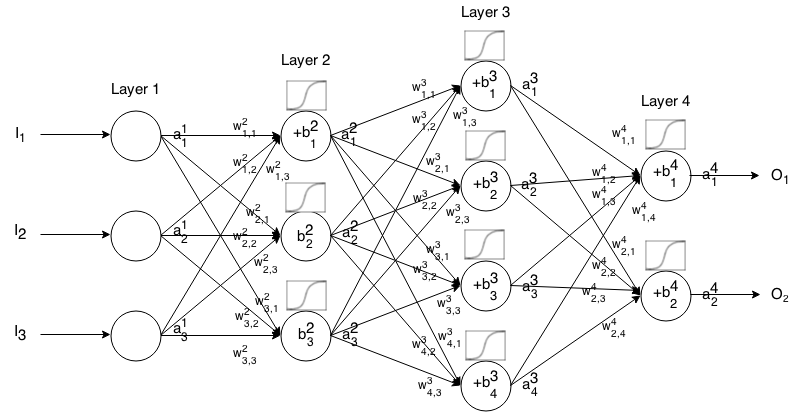




위와같은 구조를 가지고 있었으며, 이러한 구조의 경우 input data의 크기가 커지게 될 경우 모든 layer들이 fully connected이기 때문에 굉장히 많은 weight값을 update해야 합니다. 즉 parameter의 개수가 굉장히 많기 때문에 데이터가 커지면 커질 수록 학습 시키기가 쉽지 않고 overfitting되기 쉽습니다.

학자들은 이 문제를 해결하기 위해서 많은 고민 끝에 이미지 데이터의 경우에, 이미지 데이터의 특징을 활용하여 parameter의 개수를 줄이는 방법을 고안하게 됩니다. 그 방법은 바로 실제 인간의 시각 정보 처리방식을 모방한 방법이며, 굉장히 유명한 CNN(Convolutional Neural Network) 방법입니다.




<br/>
<img src="https://t1.daumcdn.net/cfile/tistory/276FC94357AB43B00D" alt="Drawing" style="width: 700px;"/>
<br/><br/>
<img src="https://ars.els-cdn.com/content/image/1-s2.0-S016516841500290X-gr1.jpg" alt="Drawing" style="width: 500px;"/>


### V1 cortex (Primary Visual Cortex)

- V1 is arranged in a spatial map $\rightarrow$ features deﬁned in terms of two-dimensional maps.

- V1 contains many simple cells $\rightarrow$ characterized by a linear function.

- V1 also contains many complex cells (invariant to small shifts) $\rightarrow$ pooling strategies such as maxout units


Convolutional Neural Network - Structure
---

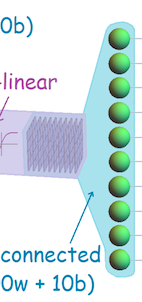


<br/>
<img src="http://cs231n.github.io/assets/cnn/convnet.jpeg" alt="Drawing" style="width: 700px;"/>


### Convolution Layer

Hyper Parameters: filter size (receptive field), depth, stride, zero-padding

- filter size (F): parameter sharing
- depth (D): the output volume
- stride (S): with which we slide the filter
- zero-padding (P): pad the input volume with zeros around the border

Ouput Size = D * {(W−F+2P)/S+1}

<h3><center>
    <a href="http://cs231n.github.io/assets/conv-demo/index.html">CS231n Convolution Layer Demo</a>
</center></h3>



### Pooling Layer

<img src="http://cs231n.github.io/assets/cnn/pool.jpeg" alt="Drawing" style="width: 400px;"/>

<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" alt="Drawing" style="width: 400px;"/>


풀링 레이어가 보통 representation의 크기를 심하게 줄이기 때문에 (이런 효과는 작은 데이터셋에서만 오버피팅 방지 효과 등으로 인해 도움이 됨), 최근 추세는 점점 풀링 레이어를 사용하지 않는 쪽으로 발전하고 있다.



### Fully Connected Layer


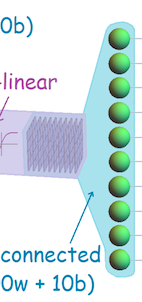


<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTtveLa9aU0XOoeUeEn0HXCl_aGRJMBqwimt_9sg29j23Ch9gpZ" alt="Drawing" style="width: 400px;"/>




## MNIST tutorial

Original Source code: https://github.com/pytorch/examples

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct,
                len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))


In [2]:
use_cuda = torch.cuda.is_available()

batch_size = 64
test_batch_size = 1000
lr = 0.01
momentum = 0.0
log_interval = 10
epochs = 10

device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
        batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
        batch_size=test_batch_size, shuffle=False, **kwargs)


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.348343
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.327447
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.317196
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.293613
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.338049
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.267504
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.300316
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.281502
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.296081
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.297963
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.246811
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.260774
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.230306
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.276591
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.267885
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.258944
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.214083
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.243981
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.206318
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.208312
Train Epoch: 1 [12800/60000 (

/home/junny/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.3247, Accuracy: 9151/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.743085
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.446102
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.701133
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.681872
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.975061
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.571199
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.645252
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.491145
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.429263
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.634662
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.525139
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.522941
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.489739
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.583809
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.709489
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.673271
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.419941
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.570132
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.696162
Train Epoch: 2 [12

Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.392290
Train Epoch: 3 [46720/60000 (78%)]	Loss: 0.385076
Train Epoch: 3 [47360/60000 (79%)]	Loss: 0.369752
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.406924
Train Epoch: 3 [48640/60000 (81%)]	Loss: 0.363077
Train Epoch: 3 [49280/60000 (82%)]	Loss: 0.286238
Train Epoch: 3 [49920/60000 (83%)]	Loss: 0.234166
Train Epoch: 3 [50560/60000 (84%)]	Loss: 0.231103
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.599041
Train Epoch: 3 [51840/60000 (86%)]	Loss: 0.310368
Train Epoch: 3 [52480/60000 (87%)]	Loss: 0.290240
Train Epoch: 3 [53120/60000 (88%)]	Loss: 0.413846
Train Epoch: 3 [53760/60000 (90%)]	Loss: 0.305533
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.320266
Train Epoch: 3 [55040/60000 (92%)]	Loss: 0.228788
Train Epoch: 3 [55680/60000 (93%)]	Loss: 0.363067
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.272032
Train Epoch: 3 [56960/60000 (95%)]	Loss: 0.485276
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.357276
Train Epoch: 3 [58240/60000 (97%)]	Loss: 0.201487


Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.308929
Train Epoch: 5 [31360/60000 (52%)]	Loss: 0.281246
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.241629
Train Epoch: 5 [32640/60000 (54%)]	Loss: 0.349732
Train Epoch: 5 [33280/60000 (55%)]	Loss: 0.362595
Train Epoch: 5 [33920/60000 (57%)]	Loss: 0.376202
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.289242
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.197006
Train Epoch: 5 [35840/60000 (60%)]	Loss: 0.274263
Train Epoch: 5 [36480/60000 (61%)]	Loss: 0.124416
Train Epoch: 5 [37120/60000 (62%)]	Loss: 0.312517
Train Epoch: 5 [37760/60000 (63%)]	Loss: 0.265537
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.157791
Train Epoch: 5 [39040/60000 (65%)]	Loss: 0.547335
Train Epoch: 5 [39680/60000 (66%)]	Loss: 0.248617
Train Epoch: 5 [40320/60000 (67%)]	Loss: 0.206620
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.319715
Train Epoch: 5 [41600/60000 (69%)]	Loss: 0.257625
Train Epoch: 5 [42240/60000 (70%)]	Loss: 0.337638
Train Epoch: 5 [42880/60000 (71%)]	Loss: 0.270164


Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.141327
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.261699
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.226921
Train Epoch: 7 [16640/60000 (28%)]	Loss: 0.186533
Train Epoch: 7 [17280/60000 (29%)]	Loss: 0.332432
Train Epoch: 7 [17920/60000 (30%)]	Loss: 0.319689
Train Epoch: 7 [18560/60000 (31%)]	Loss: 0.150873
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.190444
Train Epoch: 7 [19840/60000 (33%)]	Loss: 0.303954
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.181180
Train Epoch: 7 [21120/60000 (35%)]	Loss: 0.215849
Train Epoch: 7 [21760/60000 (36%)]	Loss: 0.249941
Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.250444
Train Epoch: 7 [23040/60000 (38%)]	Loss: 0.200856
Train Epoch: 7 [23680/60000 (39%)]	Loss: 0.253701
Train Epoch: 7 [24320/60000 (41%)]	Loss: 0.104069
Train Epoch: 7 [24960/60000 (42%)]	Loss: 0.347762
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.169380
Train Epoch: 7 [26240/60000 (44%)]	Loss: 0.110700
Train Epoch: 7 [26880/60000 (45%)]	Loss: 0.654555



Test set: Average loss: 0.0748, Accuracy: 9775/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.105317
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.172089
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.214850
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.261354
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.421245
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.227429
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.239838
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.188313
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.277647
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.223318
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.094745
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.096756
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.156179
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.189818
Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.149874
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.169915
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.185338
Train Epoch: 9 [10880/60000 (18%)]	Loss: 0.224556
Train Epoch: 9 [11520/60000 (19%)]	Loss: 0.220977
Train Epoch: 9 [12

Train Epoch: 10 [43520/60000 (72%)]	Loss: 0.208329
Train Epoch: 10 [44160/60000 (74%)]	Loss: 0.142547
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.085831
Train Epoch: 10 [45440/60000 (76%)]	Loss: 0.155535
Train Epoch: 10 [46080/60000 (77%)]	Loss: 0.203982
Train Epoch: 10 [46720/60000 (78%)]	Loss: 0.108110
Train Epoch: 10 [47360/60000 (79%)]	Loss: 0.411600
Train Epoch: 10 [48000/60000 (80%)]	Loss: 0.182836
Train Epoch: 10 [48640/60000 (81%)]	Loss: 0.079764
Train Epoch: 10 [49280/60000 (82%)]	Loss: 0.210498
Train Epoch: 10 [49920/60000 (83%)]	Loss: 0.235256
Train Epoch: 10 [50560/60000 (84%)]	Loss: 0.336776
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.092119
Train Epoch: 10 [51840/60000 (86%)]	Loss: 0.231559
Train Epoch: 10 [52480/60000 (87%)]	Loss: 0.253851
Train Epoch: 10 [53120/60000 (88%)]	Loss: 0.235640
Train Epoch: 10 [53760/60000 (90%)]	Loss: 0.549725
Train Epoch: 10 [54400/60000 (91%)]	Loss: 0.373050
Train Epoch: 10 [55040/60000 (92%)]	Loss: 0.297825
Train Epoch: 10 [55680/60000 (9

In [3]:
torch.save(model, 'test_mnist.pth')
model2 = torch.load('test_mnist.pth')
test(model2, device, test_loader)

/home/junny/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/junny/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0668, Accuracy: 9794/10000 (98%)



Convolutional Neural Network - Case Study
---

### LeNet-5 [LeCun et al. (1998)]

<img src="https://t1.daumcdn.net/cfile/tistory/2777003557AB5C0634" alt="Drawing" style="width: 700px;"/>

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQtox5IW0GC0_AEXhVeLDJ4f-5ePyxd8AzTQUyBclJMTRTtvilm" alt="Drawing" style="width: 700px;"/>

<img src="http://yann.lecun.com/exdb/lenet/gifs/f333.gif" alt="Drawing" style="width: 500px;"/>


<center>
    <a href="http://yann.lecun.com/exdb/lenet/index.html">Yann Lecun LeNet-5 Demo</a>
</center>


<img src="https://image.slidesharecdn.com/random-170910154045/95/-64-638.jpg?cb=1505089848" alt="Drawing" style="width: 700px;"/>

### AlexNet
<img src="https://image.slidesharecdn.com/cs231n2017lecture9-171204024938/95/cs231n-2017-lecture9-cnn-architecture-18-638.jpg?cb=1512355830" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture9-171204024938/95/cs231n-2017-lecture9-cnn-architecture-19-638.jpg?cb=1512355830" alt="Drawing" style="width: 700px;"/>


### ZFNet
<img src="https://image.slidesharecdn.com/cs231n2017lecture9-171204024938/95/cs231n-2017-lecture9-cnn-architecture-24-638.jpg?cb=1512355830" alt="Drawing" style="width: 700px;"/>


### VGGNet
<img src="https://image.slidesharecdn.com/cs231n2017lecture9-171204024938/95/cs231n-2017-lecture9-cnn-architecture-35-638.jpg?cb=1512355830" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture9-171204024938/95/cs231n-2017-lecture9-cnn-architecture-30-638.jpg?cb=1512355830" alt="Drawing" style="width: 700px;"/>


### GoogLeNet
<img src="https://image.slidesharecdn.com/cs231n2017lecture9-171204024938/95/cs231n-2017-lecture9-cnn-architecture-63-638.jpg?cb=1512355830" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture9-171204024938/95/cs231n-2017-lecture9-cnn-architecture-49-638.jpg?cb=1512355830" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture9-171204024938/95/cs231n-2017-lecture9-cnn-architecture-55-638.jpg?cb=1512355830" alt="Drawing" style="width: 700px;"/>


### ResNet
<img src="https://image.slidesharecdn.com/cs231n2017lecture9-171204024938/95/cs231n-2017-lecture9-cnn-architecture-65-638.jpg?cb=1512355830" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture9-171204024938/95/cs231n-2017-lecture9-cnn-architecture-79-638.jpg?cb=1512355830" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture9-171204024938/95/cs231n-2017-lecture9-cnn-architecture-77-638.jpg?cb=1512355830" alt="Drawing" style="width: 700px;"/>


### Network Comparison
<img src="https://pbs.twimg.com/media/C6u_ugFWsAI3XgZ.jpg" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture9-171204024938/95/cs231n-2017-lecture9-cnn-architecture-90-638.jpg?cb=1512355830" alt="Drawing" style="width: 700px;"/>


### Next Version...?
<img src="https://image.slidesharecdn.com/cs231n2017lecture9-171204024938/95/cs231n-2017-lecture9-cnn-architecture-100-1024.jpg?cb=1512355830" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture9-171204024938/95/cs231n-2017-lecture9-cnn-architecture-98-638.jpg?cb=1512355830" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture9-171204024938/95/cs231n-2017-lecture9-cnn-architecture-99-638.jpg?cb=1512355830" alt="Drawing" style="width: 700px;"/>



Convolutional Neural Network - Transfer Learning
---
<img src="https://image.slidesharecdn.com/dlcvd2l5transfer-160802094347/95/deep-learning-for-computer-vision-transfer-learning-and-domain-adaptation-upc-2016-4-638.jpg?cb=1470247790" alt="Drawing" style="width: 700px;"/>


### Training Dataset
<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/2d79d338c114ece1d97cde1aa06ab4cf17d38254/2-Table1-1.png" alt="Drawing" style="width: 700px;"/>

<h3><center>
    <a href="https://skymind.ai/wiki/open-datasets">Open Datasets</a>
</center></h3>


### Models
PyTorch - [TorchVision models](https://pytorch.org/docs/stable/torchvision/models.html)

Caffe - [Model zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo)

Tensorflow - [tf hub](https://www.tensorflow.org/hub/)


### ONNX - Open Neural Network Exchange Format
<img src="https://image.slidesharecdn.com/deeplearningsystems-modelserving-datainnovationsummitmarch2018-180322170608/95/model-serving-for-deep-learning-28-638.jpg?cb=1521738792" alt="Drawing" style="width: 700px;"/>

[ONNX website](http://onnx.ai/)

[ONNX Model Zoo](https://github.com/onnx/models)


Recurrent Neural Network - Introduction
---
<img src="http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg" alt="Drawing" style="width: 700px;"/>


Recurrent Neural Network - Structure
---
<img src="https://image.slidesharecdn.com/cs231n2017lecture10-171031000846/95/cs231n-2017-lecture10-recurrent-neural-networks-20-638.jpg?cb=1509408599" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture10-171031000846/95/cs231n-2017-lecture10-recurrent-neural-networks-22-638.jpg?cb=1509408599" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture10-171031000846/95/cs231n-2017-lecture10-recurrent-neural-networks-29-638.jpg?cb=1509408599" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture10-171031000846/95/cs231n-2017-lecture10-recurrent-neural-networks-30-638.jpg?cb=1509408599" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture10-171031000846/95/cs231n-2017-lecture10-recurrent-neural-networks-31-638.jpg?cb=1509408599" alt="Drawing" style="width: 700px;"/>


### LSTM
<img src="https://image.slidesharecdn.com/cs231n2017lecture10-171031000846/95/cs231n-2017-lecture10-recurrent-neural-networks-41-638.jpg?cb=1509408599" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture10-171031000846/95/cs231n-2017-lecture10-recurrent-neural-networks-95-638.jpg?cb=1509408599" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture10-171031000846/95/cs231n-2017-lecture10-recurrent-neural-networks-99-638.jpg?cb=1509408599" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture10-171031000846/95/cs231n-2017-lecture10-recurrent-neural-networks-102-638.jpg?cb=1509408599" alt="Drawing" style="width: 700px;"/>


Recurrent Neural Network - RNN Applications
---
### Translation
<img src="http://www.wildml.com/wp-content/uploads/2015/09/Screen-Shot-2015-09-17-at-10.39.06-AM-1024x557.png" alt="Drawing" style="width: 700px;"/>


### Image Captioning
<img src="https://image.slidesharecdn.com/cs231n2017lecture10-171031000846/95/cs231n-2017-lecture10-recurrent-neural-networks-63-638.jpg?cb=1509408599" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture10-171031000846/95/cs231n-2017-lecture10-recurrent-neural-networks-73-638.jpg?cb=1509408599" alt="Drawing" style="width: 700px;"/>


### Image Captioning with attention
<img src="https://image.slidesharecdn.com/cs231n2017lecture10-171031000846/95/cs231n-2017-lecture10-recurrent-neural-networks-80-638.jpg?cb=1509408599" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture10-171031000846/95/cs231n-2017-lecture10-recurrent-neural-networks-84-638.jpg?cb=1509408599" alt="Drawing" style="width: 700px;"/>

<img src="https://image.slidesharecdn.com/cs231n2017lecture10-171031000846/95/cs231n-2017-lecture10-recurrent-neural-networks-86-638.jpg?cb=1509408599" alt="Drawing" style="width: 700px;"/>

